## Бейзлайн для задачи подсчета труб на фото

#### Окружение и зависимости
в дополнение к чистому conda-окружению на python 3.11.9

In [1]:
%%capture --no-display
! pip install -r requirements.txt

In [2]:
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import os
from pathlib import Path

### Бейзлайн - наивная модель на классическом CV

#### Препроцессинг для поиска окружностей

- градации серого
- размытие

In [22]:
def preprocess(img_path: str) -> np.ndarray:
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    return blur

### Читаем и преобразуем разметку

- путь к изображению - из labels.csv -> img_path  
- количество труб - из labels.csv -> pipe_count

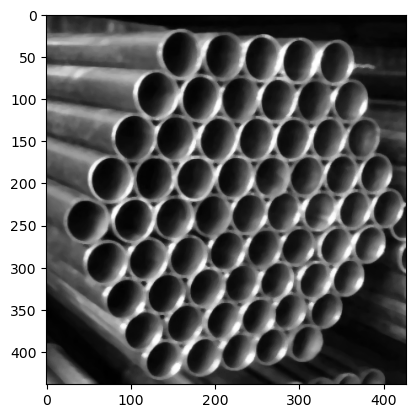

In [23]:
labels_df = pd.read_csv(f'test/annotation/labels.csv', sep=';')
img_idx = 0
img_path = labels_df['img_path'][img_idx]
annot_path = labels_df['annot_path'][img_idx]
pipe_count = labels_df['pipe_count'][img_idx]
blur = preprocess(img_path)
plt.imshow(blur, cmap='gray')
plt.show()

#### Вспомогательные функции

- вычисление средней интенсивности по центру найденной окружности
- поиск окружностей преобразованием Хафа
- фильтрация окружностей по интенсивности в центральной части (обычно внутри трубы - тень)
- подсчет окружностей на изображении по заданному пути
- получение маски по предсказанным окружностям
- получение ground truth маски из разметки
- подсчет intersection over union по маскам

In [24]:
def center_square_mean(gray: np.ndarray, x: int, y: int, r: int) -> float:
    a = int(math.sqrt(r ** 2 / 2))
    k = 0.2
    x1 = int(x - a * k)
    x2 = int(x + a * k)
    y1 = int(y - a * k)
    y2 = int(y + a * k)
    crop = gray[y1: y2, x1: x2]
    if crop.size:
        return crop.mean()
    return 255

def find_circles(img: np.ndarray) -> np.ndarray:
    img_rows = img.shape[0]
    circles=cv2.HoughCircles(
        image=img,
        method=cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=int(img_rows / 16),
        param1=50,
        param2=30,
        minRadius=int(img_rows / 100),
        maxRadius=int(img_rows / 10),
    )
    return circles

def filter_circles(circles: np.ndarray, gray: np.ndarray) -> np.ndarray:
    filtered = []
    for pt in circles[0, :]:
        x = int(pt[0])
        y = int(pt[1])
        r = int(pt[2])
        if center_square_mean(gray, x, y, r) < 50:
            filtered.append([x, y, r])
    return np.array([filtered])

def count_circles(img_path: str) -> int:
    img = preprocess(img_path)
    circles = filter_circles(find_circles(img), img)
    pipe_count_pred = circles.shape[1]
    return pipe_count_pred

def get_circles_mask(img_path: str) -> int:
    img = preprocess(img_path)
    circles = filter_circles(find_circles(img), img)
    img_draw = np.zeros_like(img)
    for pt in circles[0, :]:
        x = int(pt[0])
        y = int(pt[1])
        r = int(pt[2])
        cv2.circle(img_draw, (x, y), r, (255, 255, 255), -1)
    submission_path = f'submission/{Path(img_path).stem}.png'
    os.makedirs('submission', exist_ok=True)
    cv2.imwrite(submission_path, img_draw)
    return img_draw

def get_gt_mask(img_path: str):
    mask_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask_img[mask_img > 0] = 255
    return mask_img

def iou(mask_gt: np.ndarray, mask_pred: np.ndarray) -> float:
    intersection = np.count_nonzero(np.logical_and(mask_pred, mask_gt))
    union = np.count_nonzero(mask_gt) + np.count_nonzero(mask_pred) - intersection
    return intersection / union

#### Считаем и рисуем окружности на примере изображения

- итерируем по массиву окружностей
- отрисовываем их на оригинальном изображении

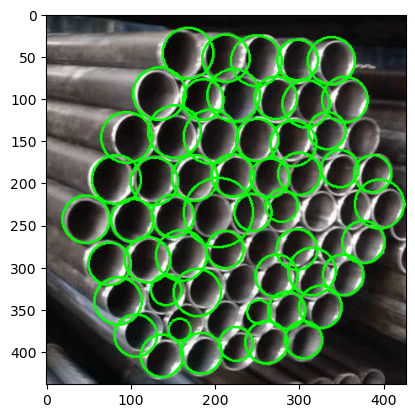

In [25]:
img_draw = cv2.imread(img_path)
circles = find_circles(blur)
circles_filtered = filter_circles(circles, blur)
for pt in circles_filtered[0, :]:
    x = int(pt[0])
    y = int(pt[1])
    r = int(pt[2])
    cv2.circle(img_draw, (x, y), r, (0, 255, 0), 2)
plt.imshow(img_draw, cmap='gray')
plt.show()

#### Отрисовываем предсказанную маску

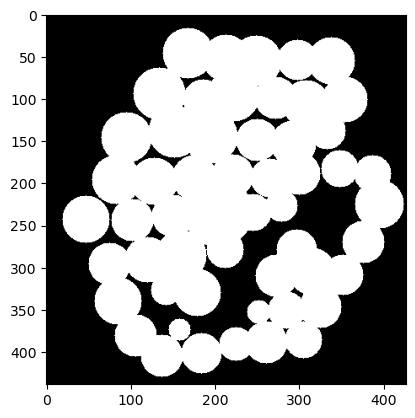

In [26]:
mask_img = get_circles_mask(img_path)
plt.imshow(mask_img, cmap='gray')
plt.show()

In [27]:
mask_img.min(), mask_img.max()

(np.uint8(0), np.uint8(255))

In [28]:
mask_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Отрисовываем истинную маску

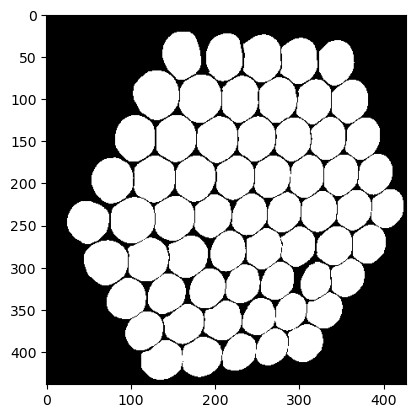

In [29]:
mask_gt = get_gt_mask(annot_path)
plt.imshow(mask_gt, cmap='gray')
plt.show()

#### Считаем ошибку на примере изображения

In [30]:
pipe_count_pred = count_circles(img_path)
error = abs((pipe_count - pipe_count_pred) / pipe_count) * 100
error.round(2)

np.float64(11.48)

#### Готовим метрики по датасету

In [31]:
labels_df = pd.read_csv('test/annotation/labels.csv', sep=';')
labels_df['pred'] = labels_df['img_path'].map(count_circles)
labels_df['abserror'] = abs(labels_df['pipe_count'].subtract(labels_df['pred']))
labels_df['abspercerror'] = labels_df['abserror'] * 100 / labels_df['pipe_count']
labels_df['mask_pred'] = labels_df['img_path'].map(get_circles_mask)
labels_df['mask_gt'] = labels_df['annot_path'].map(get_gt_mask)
labels_df['iou'] = labels_df.apply(lambda x: iou(x['mask_gt'], x['mask_pred']), axis=1)
labels_df

,img_path,annot_path,pipe_class,pipe_count,pred,abserror,abspercerror,mask_pred,mask_gt,iou
0,test/images/0/00001.jpg,test/annotation/semantic/00001.png,0,61,54,7,11.475410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.764727
1,test/images/0/00002.jpg,test/annotation/semantic/00002.png,0,30,45,15,50.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.784818
2,test/images/1/00003.jpg,test/annotation/semantic/00003.png,1,72,71,1,1.388889,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.701760


#### MAPE

In [32]:
MAPE = labels_df['abspercerror'].mean()
MAPE

np.float64(20.954766241651487)

#### IOU по семантической сегментации

In [33]:
IOU = labels_df['iou'].mean()
IOU

np.float64(0.7504349413422995)

### Создаем submission

In [34]:
results = []

for pipe_class in '0', '1':
    test_folder = f'test/images/{pipe_class}'
    for idx, fname in enumerate(os.listdir(test_folder)):
        file_path = f'{test_folder}/{fname}'
        get_circles_mask(file_path)
        results.append(
            dict(
                img_path=file_path,
                annot_path=f'{Path(file_path).stem}.png',
                pipe_class=int(pipe_class),
                pipe_count=count_circles(file_path),
            )
        )

result_df = pd.DataFrame(results)
result_df.to_csv('submission/submission.csv', sep=';', index=False)
result_df

,img_path,annot_path,pipe_class,pipe_count
0,test/images/0/00002.jpg,00002.png,0,45
1,test/images/0/00001.jpg,00001.png,0,54
2,test/images/1/00003.jpg,00003.png,1,71
